<a href="https://colab.research.google.com/github/cemorse100/MIR-2023/blob/main/Feature_extraction_medleysolosdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment : Feature extraction and classification - MIR 2022/2023

For this assignment I aimed to reprodce two notebooks which execute a feature extraction and classification of a dataset containing different classes of Mridangam strokes. 

These notebooks are applied to a dataset, Medley-Solos-DB (https://zenodo.org/record/1344103#.Y-ufuOzMLlx) which instead contains audio recordings which are classified by the instrument being played. 

This datafile contains: 
- 21571 audio clips as WAV files, sampled at 44.1 kHz, with a single channel (mono), at a bit depth of 32. 
- Fixed duration of 2972 milliseconds, that is, 65536 discrete-time samples.
- 8 Distinct instrument classes 

Here are the tasks performed in these notebooks: 

- Understanding & balancing the dataset
- Feature Extraction
- Genre classification

# Setup
In this section we will download and balance the dataset in order to prepare it for feature extraction

In [1]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 68.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=98001420bb0abc226723d0d561f519d4f3d4346708508d224f5bb8f1e2dc8d42
  Stored in directory: /root/.cache

In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

We initialize Medley Solos DB a collection of audio examples of individual instruments. The dataset comprises of 10 instrument classes. 

In this experiment we predict 10 stroke classes.
 

In [3]:
medleysolos = mirdata.initialize("medley_solos_db")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#This cell downloads and validates the medley_solos_db dataset
medleysolos.download()  # download the dataset
medleysolos.validate()  # validate that all the expected files are there

1.22MB [00:04, 319kB/s]                            
7.38GB [1:11:10, 1.86MB/s]                            
100%|██████████| 21571/21571 [01:45<00:00, 204.68it/s]


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

In [15]:
#Here we generate a list of all tracks. Since the dataset contains metadata for each track we can consider all tracks
medleysolos_ids = medleysolos.track_ids  # Load Medleysolos IDs
medleysolos_data = medleysolos.load_tracks()  # Load Medleysolos data

medleysolos_data[medleysolos_ids[0]]  # Visualize a single track
#print(medleysolos_data[medleysolos_ids[5]].instrument)

Track(
  audio_path="...t/mir_datasets/medley_solos_db/audio/Medley-solos-DB_test-0_0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3.wav",
  track_id="0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3",
  audio: The track's audio

        Returns,
  instrument: ,
  instrument_id: ,
  song_id: ,
  subset: ,
)

In [103]:
# We now create a list of the unique instrument classes
instrument_names = []
for i in medleysolos_ids:
    instrument_names.append(medleysolos_data[i].instrument)
instrument_names = np.unique(instrument_names)

print('Here are the unique instrument classes identified in our dataset')
print(instrument_names)

Here are the unique instrument classes identified in our dataset
['clarinet' 'distorted electric guitar' 'female singer' 'flute' 'piano'
 'tenor saxophone' 'trumpet' 'violin']


In [58]:
# You can create a dictionary using instruments as keys
instrument_dict = {item: [] for item in instrument_names}
for i in medleysolos_ids:
    instrument_dict[medleysolos_data[i].instrument].append(medleysolos_data[i].audio_path)

for i in instrument_dict:
  print(f'Number of elements for {i} : {len(instrument_dict.get(i))}')

Number of elements for clarinet : 1311
Number of elements for distorted electric guitar : 1854
Number of elements for female singer : 1744
Number of elements for flute : 3555
Number of elements for piano : 6032
Number of elements for tenor saxophone : 477
Number of elements for trumpet : 627
Number of elements for violin : 5971


In [102]:
#This dataset is very unbalanced. To save time we will balance it here before processing.
import random
balanced_instrument_dict = {}
files_list = []

for i in instrument_dict:
  balanced_instrument_dict[i] = random.sample(instrument_dict.get(i),100) #100 files from each class should be enough

instrument_dict = balanced_instrument_dict

for i in instrument_dict:
  print(f'Number of elements for {i} : {len(instrument_dict.get(i))}')
  [files_list.append(j) for j in instrument_dict.get(i)]

print(f'\nWe have {len(files_list)} files for {len(instrument_dict)} different classes')



Number of elements for clarinet : 100
Number of elements for distorted electric guitar : 100
Number of elements for female singer : 100
Number of elements for flute : 100
Number of elements for piano : 100
Number of elements for tenor saxophone : 100
Number of elements for trumpet : 100
Number of elements for violin : 100

We have 800 files for 8 different classes


In [64]:
#Since the instrument classes are not included in the filename for this dataset, Ive created this function to
#extract a list of instrument classes for each key value pair in our balanced dictionary. 
def add_keys_to_list(instrument_dict):
    new_instrument_list = []
    for key in instrument_dict.keys():
        for i in range(100):
            new_instrument_list.append(key)
    return new_instrument_list


In [105]:
instrument_list = add_keys_to_list(instrument_dict)

Before moving on to feature extraction lets take a look at some visualizations of the data. 

As shown below, given that each audiofile contains information throughout the whole recording we do not need to worry about preprocessing. 

Plot waveforms of random samples of each instrument type...


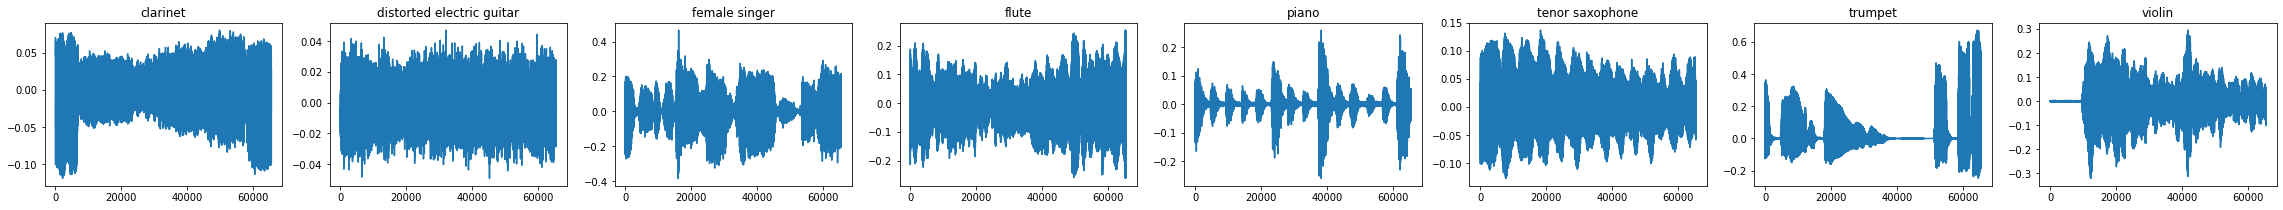

In [66]:
# Raw-data preprocess analysis parameters
_, fs = medleysolos_data[medleysolos_ids[0]].audio

num_instruments = len(instrument_dict.keys())
print("Plot waveforms of random samples of each instrument type...")
plt.figure(1, figsize=(5 * num_instruments, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, instrument in enumerate(instrument_dict.keys()):
    sample_file = instrument_dict[instrument][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_instruments,(i+1))
    plt.plot(x)
    plt.title(instrument)

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [67]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='keep',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(medleysolos_data[medleysolos_ids[0]].audio_path)


scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: medleysolos_analysis.csv

In [78]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = '/content/drive/MyDrive/medleysolos_analysis.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in files_list:
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='keep',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = instrument_list[int(file_count)-1]
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

20 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_training-0_9f6d4046-3662-5433-fc44-98c80a428fd8.wav
40 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_test-0_7adb93d5-faee-521b-fe99-117bba7e6aa8.wav
60 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_test-0_030121e8-7004-538d-f944-500bad01d40a.wav
80 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_training-0_b93c28fd-cdb9-50d9-f3ac-f8ef4cce342b.wav
100 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_training-0_af3b693e-874a-5e07-fae8-a4f8ab0425e3.wav
120 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_validation-1_b9317fba-bccb-5fae-f132-791e8017986d.wav
140 files processed, current file:  /root/mir_datasets/medley_solos_db/audio/Medley-solos-DB_test-1_38af762b-6a71-5c60-f959-3d8777db7721.wav

In [79]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.986485,16.137585,2.854650,0.440354,0.046050,3.533163,5.387850,1.585198,1.314781,4.652485,...,428.102356,6.583709,1.664342,1167503.125,4.679665e+05,3.604831,1.952415,0.029482,0.008874,clarinet
1,0.960058,16.703074,4.317982,0.390302,0.069234,4.026202,7.205310,1.280914,1.297541,6.017007,...,519.908691,4.909033,1.626673,1875093.625,1.036963e+06,1.397450,1.750989,0.029316,0.014456,clarinet
2,0.989022,17.286232,4.865179,0.379137,0.050587,2.666015,3.880915,0.477517,1.172807,9.107632,...,531.278015,2.555879,0.741637,1990577.375,6.084969e+05,2.655199,2.983301,0.057791,0.019724,clarinet
3,0.832181,18.056297,5.766200,0.428147,0.093486,23.127003,44.049374,3.228702,3.114851,4.811037,...,446.049927,5.266436,1.917410,1580872.000,1.654716e+06,1.075566,0.944310,0.027684,0.011439,clarinet
4,0.989167,16.251318,4.867145,0.378412,0.059585,2.343408,4.403314,0.602891,0.911431,10.142206,...,652.699829,2.489532,0.937021,2057679.250,1.223489e+06,2.319118,1.841064,0.057284,0.015763,clarinet


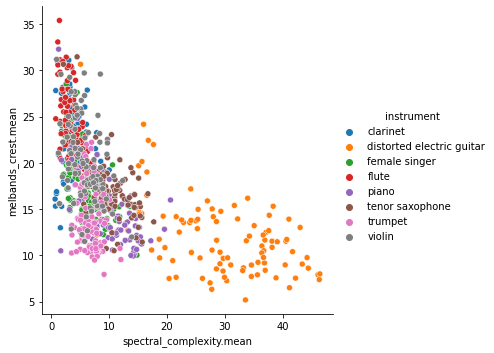

In [84]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "spectral_complexity.mean", y = "melbands_crest.mean", hue = "instrument", data = data);